In [26]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# datos

In [28]:
path = 'modelo2.4'
data_path = "img/anime_faces"
weights_path = path+'/weights'
numpy_path= path+'/np'
IMG_SIZE =  (64,64)
latent_dim = 100
BATCH_SIZE = 128

In [29]:
dataset = keras.preprocessing.image_dataset_from_directory(
  data_path , label_mode=None, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
dataset = dataset.map(lambda x: x / 255.0)


Found 63565 files belonging to 1 classes.


(128, 64, 64, 3)


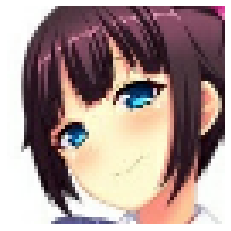

In [30]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    print(x.shape)
    break

# modelo

## creacion

In [31]:
def discriminator():
    init = tf.keras.initializers.RandomNormal(stddev=0.02)

    model = keras.models.Sequential()
  

    model.add(layers.Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(IMG_SIZE[0],IMG_SIZE[1],3),kernel_initializer=init))
    model.add(layers.LeakyReLU(alpha=0.2)) 

    model.add(layers.Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2)) 

    model.add(layers.Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2)) 
    
    model.add(layers.Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(layers.Flatten())
    model.add(layers.Activation('sigmoid'))
    return model
discriminator = discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1728      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73728     
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         819200    
                                                      

In [32]:
def generator():
    init = tf.keras.initializers.RandomNormal(stddev=0.02)

    model = keras.models.Sequential()
  
    model.add(layers.Dense(4*4*1024,kernel_initializer=init,input_dim=latent_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4,4,1024))) 

   
    model.add(layers.Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())  
   
    model.add(layers.Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) 
   
    model.add(layers.Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) 

    model.add(layers.Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(layers.Activation('tanh')) 
    return model
generator = generator()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_10 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 512)        13107200  
 ranspose)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 8, 8, 512)       

In [33]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        
        with tf.GradientTape() as disc_tape1:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            real_targets = tf.ones_like(real_output)
            d_loss = self.loss_fn(real_targets, real_output)

        gradients_of_disc1 = disc_tape1.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_disc1,self.discriminator.trainable_variables))
            
      
        with tf.GradientTape() as disc_tape2:
            fake_output = self.discriminator(generated_images, training=True)
            fake_targets = tf.zeros_like(fake_output)
            disc_loss2 = self.loss_fn(fake_targets, fake_output)
        gradients_of_disc2 = disc_tape2.gradient(disc_loss2, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_disc2,self.discriminator.trainable_variables))


        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            real_targets = tf.ones_like(fake_output)
            gen_loss = self.loss_fn(real_targets, fake_output)

        gradients_of_gen = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_gen,self.generator.trainable_variables)) 

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(gen_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [34]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100,path='generadas',test_vector=None):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.path = path
        

        if not os.path.exists(path):
            os.makedirs(path)
        if not os.path.exists(path+'/img'):
            os.makedirs(path+'/img')
        if not os.path.exists(path+'/weights_auto_save'):
            os.makedirs(path+'/weights_auto_save')
        if not os.path.exists(path+'/np'):
            os.makedirs(path+'/np')
            
        if  test_vector is None :
            self.random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            np.save(path+'/np/origen',self.random_latent_vectors )
        else :
            self.random_latent_vectors = test_vector
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        if(epoch%10==0):
            self.model.save_weights(f'{self.path}/weights_auto_save/{epoch}', save_format='tf')
       
        generated_images = self.model.generator(self.random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.imshow((generated_images[i].numpy()).astype("int32"))
        img.save(f'{self.path}/img/generated_img_{epoch}_{i}.png')
        plt.show()
            
            

## entrenamiento

In [35]:
epochs = 100 

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 ),
    g_optimizer=tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 ),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
training = gan.fit(
    dataset, epochs=epochs, callbacks=GANMonitor(1, path = path) 
)

# resultados modelo 

## img random 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


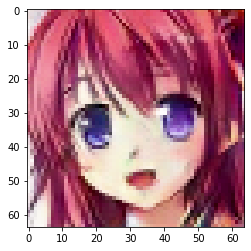

In [60]:
test_vect =  tf.random.normal(shape=(2, latent_dim))
test = generator.predict(test_vect)
original = test[0]
plt.imshow(test[0])
np.save(numpy_path+'/random',test_vect[0])

## modificar imagen random

In [82]:
from ipywidgets import GridspecLayout,Button,Layout
from matplotlib import pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output
output = w.Output()



def dict_to_arr(d):    
    dictlist=[]
    for x in d.items():
        temp = x[1]
        dictlist.append(temp)
    return dictlist
def on_button_clicked_random():    
    seed = tf.random.normal(shape=(2, latent_dim))[0]
    for i , s in enumerate(sliders):
        s.value = seed[i]
    return seed
def create_grid(kwargs,latent_dim, columnas = 10):
    grid = GridspecLayout(10, 11)
    filas = latent_dim//columnas 
    for i in range(filas):
        for j in range(columnas):
            if (i-1)*filas+(j-1) >= latent_dim:
                break
            grid[i, j] = sliders[(i-1)*10+(j-1)]
    return grid 
def update_chart(change):
    with output:
        clear_output()
        x = [s.value for s in sliders]
        test_vect = np.zeros(shape=(2, latent_dim))
        test_vect[0] =  tf.convert_to_tensor(x, dtype=tf.float32)
        test = generator.predict(test_vect)

        f = plt.figure()
        f.add_subplot(1,2, 1)
        plt.imshow(test[0])
        f.add_subplot(1,2, 2)
        plt.imshow(original)
        plt.show(block=True)
        
        
def funtion_to_sliders(sliders):        
    for s in sliders:
        s.observe(update_chart, 'value')
    return sliders
def guardar_numpy(b):
    with output:
        x = [s.value for s in sliders]
        x = np.array(x)
        np.save(numpy_path+'/modificada',x)

seed =test_vect[0]

kwargs = {'seed[{}]'.format(i) : 
          widgets.FloatSlider(  min = -1.0, 
                                max = 1.0, 
                                step = 0.01, 
                                value = seed[i]) 
          for i in range(latent_dim)}
# crear array de sliders 
sliders = dict_to_arr(kwargs)
sliders = funtion_to_sliders(sliders)
grid = create_grid(kwargs,latent_dim)

guardar = widgets.Button(description="guardar")
guardar.on_click(guardar_numpy)

random = widgets.Button(description="random")
random.on_click(on_button_clicked_random)

In [83]:
w.VBox([grid,output,guardar,random])

# weights

In [36]:
gan.load_weights('modelo2.4/weights_auto_save/final')

In [16]:
gan.save_weights(path+'/weights_auto_save/final', save_format='tf')